# 机器学习进阶毕业项目—驾驶员状态检测

### 一、数据预处理

#### 1、根据司机ID划分训练集和验证集，将P064, P066两位司机，共1854个数据作为验证集，其余26位司机，共20570个数据作为训练集。将验证集从原始文件里移动到验证集相应的分类文件里。

In [1]:
import os
import pandas as pd
import numpy as np
import shutil

valid_subjects = ['p021','p051','p035']

if not os.path.exists("input/valid"):
    os.mkdir("input/valid")
    for i in range(10):
        os.mkdir("input/valid/c%d"%i)

df = pd.read_csv(os.path.join('input', "driver_imgs_list.csv"))

for valid_subject in valid_subjects:
    df_valid = df[(df["subject"]==valid_subject)]
    for index, row in df_valid.iterrows():
        subpath = row["classname"] + "/" + row["img"]
        if os.path.exists(os.path.join('input',"train",subpath)):
            shutil.move(os.path.join('input',"train",subpath), os.path.join('input',"valid",subpath),)
        else:
            print("cannot move {} : {}".format(row["subject"],subpath))

### 二、导出特征向量

In [47]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.models import load_model

import h5py
import math

def write_gap(MODEL, image_size, lambda_func=None,weights_name=None):
    #width = image_size[0]
    #height = image_size[1]
    input_tensor = Input((*image_size, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights=None, include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    model.load_weights("weights/"+weights_name, by_name=True)
    
    batch_size=16
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(os.path.join('input', 'train'), image_size, shuffle=False, batch_size=batch_size,class_mode='categorical')
    valid_generator = gen.flow_from_directory(os.path.join('input', 'valid'), image_size, shuffle=False, batch_size=batch_size,class_mode='categorical')
    test_generator = gen.flow_from_directory(os.path.join('input', 'test'), image_size, shuffle=False, batch_size=batch_size, class_mode=None)

    train = model.predict_generator(train_generator,verbose=1)
    valid = model.predict_generator(valid_generator, verbose=1)
    test = model.predict_generator(test_generator, verbose=1)
    
    with h5py.File("gap_76_a_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("valid", data=valid)
        h.create_dataset("test", data=test)
        h.create_dataset("train_label", data=train_generator.classes)
        h.create_dataset("valid_label", data=valid_generator.classes)

#write_gap(ResNet50, (224, 224), resnet50.preprocess_input, weights_name='ResNet50-finetune_120_a.h5')
#write_gap(ResNet50, (224, 224), resnet50.preprocess_input, weights_name='ResNet50-finetune_78.h5')
#write_gap(InceptionV3, (299,299), inception_v3.preprocess_input, weights_name='InceptionV3-finetune_168_c.h5')
#write_gap(Xception, (299,299), xception.preprocess_input, weights_name='Xception-finetune_81.h5')
write_gap(Xception, (299,299), xception.preprocess_input, weights_name='Xception-finetune_76.h5')
#write_gap(InceptionResNetV2, (299,299), inception_resnet_v2.preprocess_input, weights_name='InceptionResNetV2-finetune_301_a.h5')
#write_gap(VGG16, (224, 224))

Found 19419 images belonging to 10 classes.
Found 3005 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
4983/4983 [==============================] - 1965s 394ms/step


### 三、载入特征向量

In [76]:
import h5py
import numpy as np
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
np.random.seed(2018)

X_train = []
X_valid = []
X_test = []

#gap_a_Xception.h5
#gap_a_InceptionV3.h5
#gap_a_InceptionResNetV2.h5
#gap_a_ResNet50.h5
#gap_120_a_ResNet50.h5

for filename in ["gap_a_ResNet50.h5","gap_a_InceptionV3.h5","gap_a_Xception.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['train_label'])
        y_valid = np.array(h['valid_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)

In [77]:
print(y_train.shape)
print(y_valid.shape)
print(X_test.shape)

(19419, 10)
(3005, 10)
(79726, 6144)


### 四、构建模型

In [81]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
#from keras.optimizers import SGD

np.random.seed(2018)

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
#x = Dense(2048, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model = Model(input_tensor, x)

#sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9)

#model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy',metrics=['accuracy'])

### 五、训练模型

#### 1、训练结果可视化，查看模型训练过程中的acc+loss+val_acc+val_loss

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

#### 2、训练模型，为了避免过拟合采用Earlystopping。

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 19419 samples, validate on 3005 samples
Epoch 1/60
19419/19419 [==============================] - 2s 95us/step - loss: 2.2705 - acc: 0.2131 - val_loss: 1.6579 - val_acc: 0.5903
Epoch 2/60
19419/19419 [==============================] - 1s 48us/step - loss: 1.4766 - acc: 0.5497 - val_loss: 1.0721 - val_acc: 0.9434
Epoch 3/60
19419/19419 [==============================] - 1s 48us/step - loss: 0.9973 - acc: 0.8026 - val_loss: 0.7350 - val_acc: 0.9704
Epoch 4/60
19419/19419 [==============================] - 1s 48us/step - loss: 0.7063 - acc: 0.9096 - val_loss: 0.5361 - val_acc: 0.9757
Epoch 5/60
19419/19419 [==============================] - 1s 48us/step - loss: 0.5341 - acc: 0.9496 - val_loss: 0.4111 - val_acc: 0.9780
Epoch 6/60
19419/19419 [==============================] - 1s 49us/step - loss: 0.4188 - acc: 0.9648 - val_loss: 0.3292 - val_acc: 0.9780
Epoch 7/60
19419/19419 [==============================] - 1s 52us/step - loss: 0.3398 - acc: 0.9712 - val_loss: 0.2732 - val_acc:

19419/19419 [==============================] - 1s 48us/step - loss: 0.0296 - acc: 0.9930 - val_loss: 0.0773 - val_acc: 0.9784


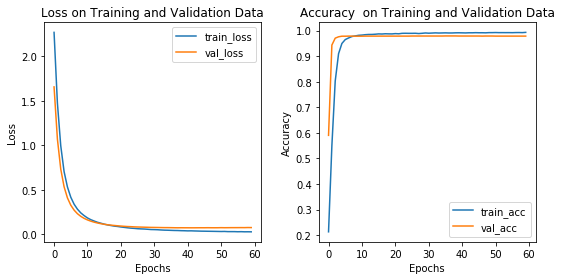

In [82]:
from keras.callbacks import EarlyStopping

callback= [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
hist=model.fit(X_train, y_train, batch_size=128, nb_epoch=60, validation_data=(X_valid, y_valid),callbacks=callback)
training_vis(hist)

### 六、预测测试集

#### 1、创建提交文件格式。

In [6]:
import datetime
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

#### 2、获取测试集ID

In [7]:
import pandas as pd
import numpy as np
import glob
def get_test_id():
    X_test_id = []
    print('get test ID')

    path = os.path.join( 'input', 'test', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    for fl in files:
        flbase = os.path.basename(fl)
        X_test_id.append(flbase)
    print(len(X_test_id))
    return X_test_id

#### 3、预测测试集并保存预测结果。

In [83]:
y_pred = model.predict(X_test, verbose=1)
#y_pred = y_pred.clip(min=0.005, max=0.995)

79726/79726 [==============================] - 4s 51us/step


In [84]:
test_id=get_test_id()
info_string = 'loss_mix_model' \
                + '_ResNet50_120_a'\
                + '_InceptionV3'\
                + '_Xception_y1_g'
create_submission(y_pred, test_id, info_string)
print("submission done")

get test ID
79726
submission done
